# 3D Segmentation of Brain Tumor

This document is to test the methodology and refine it for execution in FYP B.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# code for Google Colab Users
%pip install monai==0.9.0
%pip install monai[einops]
%pip install pytorch_lightning

In [18]:
from monai.data import Dataset, CacheDataset,PersistentDataset, decollate_batch, list_data_collate
from glob import glob
from os import path, listdir
import pytorch_lightning as pl
from sklearn.model_selection import ShuffleSplit

from monai.transforms import (
    LoadImaged,
    SpatialPadd,
    EnsureChannelFirstd,
    Compose,
    NormalizeIntensityd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    MapTransform,
    CropForegroundd,
    EnsureTyped,
    EnsureType,
    Activations,
    AsDiscrete,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandSpatialCropSamplesd
)

from monai.data import partition_dataset
from monai.networks.nets import UNet,UNETR, SegResNet, BasicUnet
from monai.losses import TverskyLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import torch
import matplotlib.pyplot as plt
import numpy as np
import utilities.split_data as split_data
plt.style.use(['science','ieee'])
%matplotlib inline

In [2]:
base_path = r"/content/drive/MyDrive/BraTS_2020/Training"
base_path = r"D:\University\OneDrive - UCSI University\FYP 2022\Code\3D-Segmentation-of-Glioblastoma-from-MRI\Datasets\2020\MICCAI_BraTS2020_TrainingData"
# Base Path to the training Dataset

In [4]:
pl.seed_everything(420) #seed value for globally

Global seed set to 420


420

As there are 3 Main Classes to be identified:
1. Non-Enhancing, $c_1$
2. Edema, $c_2$
3. [`Skipped`]
4. Enhancing $c_3$
5. No Tumor, Normal Tissue, $c_{none}$

One-Hot Encoding is done on the segmented dataset to bring each Data point in the segmentation mask into an array similar to
$$
 \overbrace{(c_1 | c_2 | c_3 | c_{none})}^{\text{A Segmented voxel}} \rightarrow  \begin{bmatrix}c_1\\c_2\\c_3\end{bmatrix} 
$$

where each point will correspond to a a class mentioned above. If all elements within the array are 0, then it means that the point is not classified as a malignancy (no tumor).

In [5]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks. Moving 4 to 3.
class ConvertLabelsIntoOneHotd(MapTransform):
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                data_dict[key] == 1,  # Non Enhancing Tumor Core
                data_dict[key] == 2,  # Edema Core
                data_dict[key] == 4,  # Enhancing Tumor Core
            ]
            data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
        return data_dict


In [31]:
cases = [path.join(base_path, x) for x in listdir(base_path)]
# Appends all cases to a list

mri_images = [
    {
        "image": [
            path.join(case, f"{path.split(case)[-1]}_t1ce.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_t2.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_flair.nii.gz"),
        ],
        "seg": path.join(case, f"{path.split(case)[-1]}_seg.nii.gz"),
    }
    for case in cases[:30]  #! Only 30 cases taken as test slice
]
# Extract the path to the training nifti files of each case. Chosen are t1ce, t2 and flair. Segmentation is also extracted.

training_data, validation_data = partition_dataset(
    mri_images, ratios=[0.7, 0.3], shuffle=True
)
# 70 - 30 split of the training data.


# TODO: Research more about the following transforms as well as importance of transforms for MRI data.
transform_images_train = Compose(
    [
        LoadImaged(keys=["image", "seg"]),  # Loads the images and segmentation
        EnsureChannelFirstd(
            keys=["image"]
        ),  # Ensures that the images are in the correct format, ie channel is first dimension.
        ConvertLabelsIntoOneHotd(
            keys=["seg"]
        ),  # Converts the segmentation into one hot encoding
        # RandSpatialCropd(
        #     keys=["image", "seg"], roi_size=[224, 224, 144], random_size=False
        # ),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        CropForegroundd(keys=["image", "seg"], source_key="image"),
        # RandSpatialCropSamplesd(
        #     keys=["image", "seg"],
        #     num_samples=4,
        #     roi_size=(80, 80, 80),
        #     random_size=False,
        # ),
        RandCropByLabelClassesd(
            keys=["image", "seg"],
            label_key="seg",
            # image_key="image",
            spatial_size=(80, 80, 80),
            num_samples=4,
            num_classes=3,
            # ratios=[],
        ),
        # RandCropByPosNegLabeld(
        #     keys=["image", "seg"],
        #     label_key="seg",
        #     image_key="image",
        #     spatial_size=(80, 80, 80),
        #     num_samples=4,
        #     neg=0
        # ),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        RandFlipd(
            keys=["image", "seg"], prob=0.5, spatial_axis=2
        ),  # Three Random flips along the three axes
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),  # Normalise Intensity of the images
        # Ensure spacing of voxels are uniform among scans
        EnsureTyped(keys=["image", "seg"]),
    ]
)
# Defines the transformations to be applied to the training data.

transform_images_validation = Compose(
    [
        LoadImaged(keys=["image", "seg"]),  # Loads the images and segmentation
        EnsureChannelFirstd(
            keys=["image"]
        ),  # Ensures that the images are in the correct format, ie channel is first dimension.
        ConvertLabelsIntoOneHotd(
            keys=["seg"]
        ),  # Converts the segmentation into one hot encoding
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),  # Normalise Intensity of the images
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),  # Ensure spacing of voxels are uniform among scans
        EnsureTyped(keys=["image", "seg"]),
    ]
)
# Defines the transformations to be applied to the testing data.


persistent_dataset_path = (
    r"./cache"  # Path of the persistent dataset cache, to speed up training process
)

dataset_training = Dataset(
    training_data, transform=transform_images_train
)  # Preparation of the training dataset <- Testing and debugging

# dataset_validation = Dataset(
#     validation_data, transform=transform_images_validation
# )  # Preparation of the validation dataset <- Testing and debugging

# dataset_training = PersistentDataset(
#     mri_images, transform=transform_images_train, cache_dir=persistent_dataset_path
# )  # Preparation of the training dataset


In [25]:
dataset_training[0][0]['image'].shape
# first 0 refers to case 
# second 0 refers to sample from case

torch.Size([3, 80, 80, 80])

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


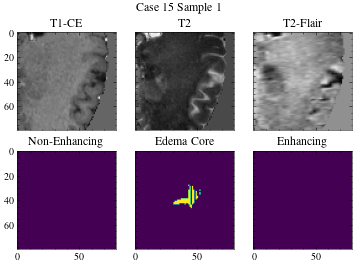

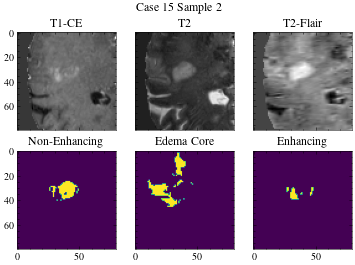

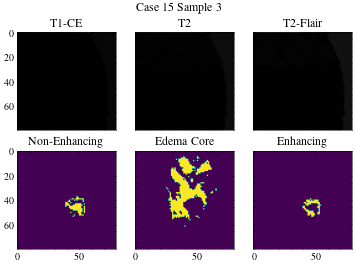

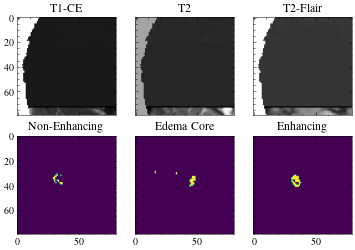

In [32]:
slice = 40
sample=0
case = 15

to_plot_dataset = dataset_training[case]


for sample in range(4):
    fig.suptitle(f"Case {case} Sample {sample}")
    fig, ax = plt.subplots(2,3,sharey=True,sharex=True)
    ax[1,0].imshow(to_plot_dataset[sample]['seg'][0][slice,:,:])
    ax[1,0].set_title("Non-Enhancing")
    ax[1,1].imshow(to_plot_dataset[sample]['seg'][1][slice,:,:])
    ax[1,1].set_title("Edema Core")
    ax[1,2].imshow(to_plot_dataset[sample]['seg'][2][slice,:,:])
    ax[1,2].set_title("Enhancing")


    ax[0,0].imshow(to_plot_dataset[sample]['image'][0][slice,:,:],cmap='gray')
    ax[0,0].set_title("T1-CE")

    ax[0,1].imshow(to_plot_dataset[sample]['image'][1][slice,:,:],cmap='gray')
    ax[0,1].set_title("T2")

    ax[0,2].imshow(to_plot_dataset[sample]['image'][2][slice,:,:],cmap='gray')
    ax[0,2].set_title("T2-Flair")

    fig.show()

In [14]:
# Defining a Basic to Learn and test with limited Dataset
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # self.model = UNet(
        #     spatial_dims=3,
        #     in_channels=3,
        #     out_channels=3,
        #     channels=(16, 32, 64, 128, 256),
        #     strides=(2, 2, 2, 2),
        # )

        self.model = SegResNet(
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            init_filters=16,
            in_channels=3,
            out_channels=3,
            dropout_prob=0.2,
        )
        
        self.best_val_dice = 0
        self.best_val_epoch = 0

        self.post_pred_image = Compose(
            [
                EnsureType(),
                Activations(softmax=True),
                AsDiscrete(argmax=True, to_onehot=3),
            ]
        )

        self.post_pred_seg = Compose(
            [EnsureType(), Activations(softmax=True), AsDiscrete(to_onehot=3)]
        )

        self.batch_size = 5  #! Adjust with tuning Later
        self.num_workers = 2  #! Change for Machine / Temporarily omitted
        self.learning_rate = 1e-4  #! Adjust with tuning Later

        self.loss_function = DiceLoss(
            to_onehot_y=False, sigmoid=True, squared_pred=True
        )
        self.dice_metric = DiceMetric(include_background=True, reduction="mean")

    def forward(self, x):
        return self.model(x)

    def prepare_data(self):
        # Make the Datasets based on the sequence of data. To be passed into Data Loaders later.
        self.train_ds = PersistentDataset(
            training_data, transform=transform_images_train, cache_dir="./cache"
        )  # Preparation of the training dataset <- Testing and debugging

        self.val_ds = PersistentDataset(
            validation_data, transform=transform_images_validation, cache_dir="./cache"
        )  # Preparation of the validation dataset <- Testing and debugging

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.batch_size,
            collate_fn=list_data_collate,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        image, seg = batch["image"], batch["seg"]
        output = self.forward(image)
        loss = self.loss_function(output, seg)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        image, seg = batch["image"], batch["seg"]
        output = sliding_window_inference(
            inputs=image,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=self.forward,
            overlap=0.5,
        )
        loss = self.loss_function(output, seg)
        output = [self.post_pred_image(i) for i in decollate_batch(output)]
        self.dice_metric(y_pred=output, y=seg)
        return {"val_loss": loss, "val_number": len(output)}
    
    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        
        tensorboard_logs = {
            'val_dice': mean_val_dice,
            'val_loss': mean_val_loss
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}


In [15]:
# Declaring Logger
log_dir = r'./logs'
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir=log_dir
)


In [18]:
# Instantiating Model and tuning before training

net = Model()
trainer = pl.Trainer(
    accelerator="gpu",
    gpus=1,
    max_epochs=50,
    auto_lr_find=True,
    auto_scale_batch_size=True,
    logger=tb_logger,
    progress_bar_refresh_rate=20
)


Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(net)

In [19]:
trainer.fit(net)

Missing logger folder: ./logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | model         | UNet     | 2.0 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.925     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
import shutil
import os
def clear_cache_dir():
    cwd = os.getcwd()
    shutil.rmtree(os.path.join(cwd, 'cache'))
    
clear_cache_dir()

In [ ]:
torch.cuda.empty_cache()
# in case your GPU crashes and memory needs to be flushed